To Do:
- Add Budget constraint

# Portfolio Optimization

Adapted from: https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html

We are given a set of $n$ assets $\{1, 2, ..., n\}$, each with an expected return $\mu_i$.
We assume that all assets have the same price and we have a binary choice: either choose an asset of do not.
We wish to find the maximum return:
$$ \max_{x_i} \left( \sum_i \mu_i x_i \right) = \min_{x_i} \left( - \sum_i \mu_i x_i \right)$$
where $x_i \in \{0, 1\}$ indicates a decision:
- $x_i=1$ pick asset $i$
- $x_i=0$ don't pick asset $i$

However we also want to take risk into account, which can be done via the covariances between the assets $\sigma_{ij}$.
Thus we want to minimize the following cost function:
$$C(\{x_i\}) = - \sum_i \mu_i x_i  + q\sum_{ij} \sigma_{ij} x_i x_j$$
where $q$ is the risk factor. 

To understand this cost function note that:
- For $q=0$ we just pick the best assests based on expected return
- For $q>0$ we take volatility into account
- For $q >>0$ we pick the assets with low variance and negative covariance

For more on the portfolio model see [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp

from scipy.optimize import minimize

from datetime import datetime

## Create the Data
We will use randomly generated data using `RandomDataProvider`.
The number of assets `num_assets` will equal the number of qubits required in the quantum computation.

In [2]:
num_assets = 6

stocks = [("Company %i" % i) for i in range(1, 1+num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime(2016, 1, 1),
    end=datetime(2017, 1, 1),
    seed=4,
)
data.run()

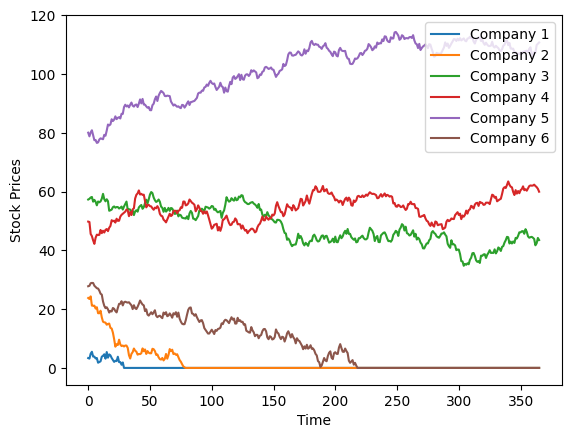

In [3]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.ylabel("Stock Prices")
plt.xlabel("Time")
plt.show()

## Define Terms
If $p_i^{(t)}$ is the price at time $t$ for asset $i$ then define $d_i^{(t)}$ as the return at time $t$
$$ d_i^{(t)} = \frac{p_i^{(t+1)} - p_i^{(t)}}{p_i^{(t)}} $$

To compute $\mu_i$ we calculate the mean return over the whole period:
$$ \mu_i = \frac{1}{T} \sum_t d_i^{(t)} $$
and similarly for the covariance
$$ \sigma_{ij} = \frac{1}{T-2} \sum_t (d_i^{(t)} - \mu_i ) (d_j^{(t)} - \mu_j ) $$
where $T$ is the total number of timesteps.

In [4]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

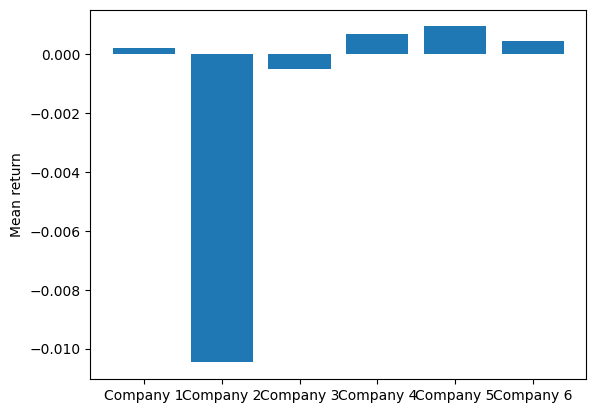

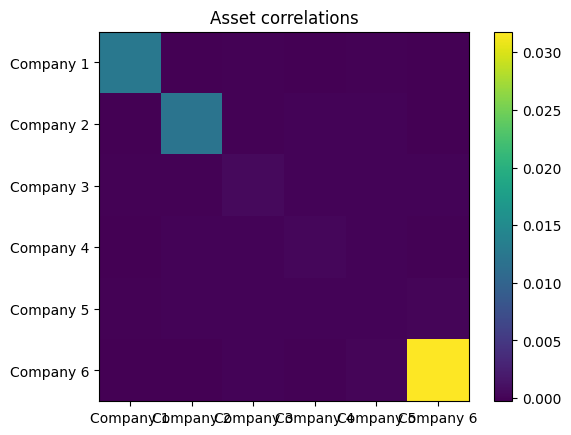

In [5]:
plt.figure()
plt.bar(range(num_assets), mu)
plt.xticks(range(num_assets), stocks)
plt.ylabel('Mean return')

plt.figure()
plt.imshow(sigma)
plt.xticks(range(num_assets), stocks)
plt.yticks(range(num_assets), stocks)
plt.title('Asset correlations')
plt.colorbar()
plt.show()

## Classial Solution
Here we minimize the cost function by seacrhing through all the combinations of $\{x_i\}$. This scales as $2^{n}$.

In [6]:
# Set the risk factor
q = 2.0

In [7]:
def cost_func(x):
    return - np.sum(x * mu) + q * np.sum(np.outer(x, x) * sigma)

def bin_string_to_cost(bin_string):
    x = np.array(list(bin_string), dtype=int)
    return cost_func(x)

In [8]:
costs = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    costs.append(bin_string_to_cost(bin_i))
    print(f"Assets: {bin_i} Cost: {costs[-1]}")

best_assets = np.binary_repr(np.argmin(costs), num_assets)

print(f"\nBest solution: {best_assets} Cost: {min(costs)}")

Assets: 000000 Cost: 0.0
Assets: 000001 Cost: 0.06313699073359468
Assets: 000010 Cost: -0.0007599932445126216
Assets: 000011 Cost: 0.06291390934778296
Assets: 000100 Cost: 1.7273242953000758e-05
Assets: 000101 Cost: 0.06275824333748901
Assets: 000110 Cost: -0.0007863769433265408
Assets: 000111 Cost: 0.062491505009910374
Assets: 001000 Cost: 0.0014868595913261444
Assets: 001001 Cost: 0.06468687390588207
Assets: 001010 Cost: 0.0007176181936001902
Assets: 001011 Cost: 0.06445454436685702
Assets: 001100 Cost: 0.0015348921168430033
Assets: 001101 Cost: 0.06433888579234026
Assets: 001110 Cost: 0.0007219937773501293
Assets: 001111 Cost: 0.0640628993115483
Assets: 010000 Cost: 0.03455354961270812
Assets: 010001 Cost: 0.09692760530994787
Assets: 010010 Cost: 0.03377247778385444
Assets: 010011 Cost: 0.0966834453397951
Assets: 010100 Cost: 0.03466140931666675
Assets: 010101 Cost: 0.09663944437484785
Assets: 010110 Cost: 0.03383668054604615
Assets: 010111 Cost: 0.09635162746292814
Assets: 011000 C

## Quantum Solution

To Solve on a QC, we change to $x_i=(1-z_i)/2$
$$
\begin{split}
C(\{z_i\}) &= \frac{1}{2} \sum_i (\mu_i z_i-\mu_i) + \frac{q}{4}\sum_{ij} (\sigma_{ij} - \sigma_{ij} z_j  - \sigma_{ij} z_i + \sigma_{ij} z_i z_j) \\
&= \frac{1}{4} \sum_i (q\sigma_{ii}-2\mu_i) + \frac{q}{4}\sum_{ij} \sigma_{ij} + \frac{1}{4} \sum_i \left(2 \mu_i  - q\sum_{j} \sigma_{ij} - q\sum_{j} \sigma_{ji} \right) z_i + \frac{q}{4}\sum_{i \ne j} \sigma_{ij} z_i z_j  \\
&= \text{const} + \frac{1}{4}\left(\sum_i  c_i z_i + q\sum_{i \ne j} \sigma_{ij} z_i z_j \right) \\
\end{split}
$$
Now we have the Quantum Hamiltonian:
$$H = \sum_i  c_i Z_i + q\sum_{i \ne j} \sigma_{ij} Z_i Z_j $$

Given an ansatz $|\psi(\theta)\rangle$ we minimize $\langle \psi(\theta)|H|\psi(\theta)\rangle$ to find our solution.

In [9]:
c = 2*mu - q*sigma.sum(0) - q*sigma.sum(1)
const = - 0.5 * mu.sum() + q * 0.25 * (sigma.sum() + sigma.trace())

In [10]:
def construct_hamiltonian(single_coefs, double_coefs):
    """Builds the quantum hamiltonian operator"""
    operators = []
    coefs = []

    for i in range(num_assets):
        op = ['I'] * num_assets
        op[i] = 'Z'
        operators.append(Pauli(''.join(op)))
        coefs.append(single_coefs[i])
        
    for i in range(num_assets-1):
        for j in range(i+1, num_assets):
            op = ['I'] * num_assets
            op[i] = 'Z'
            op[j] = 'Z'
            operators.append(Pauli(''.join(op)))
            coefs.append(double_coefs[i, j] + double_coefs[j, i])

    return SparsePauliOp(operators, coefs)

In [11]:
hamiltonian = construct_hamiltonian(c, q * sigma)
hamiltonian

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'ZIZIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZZIII', 'IZIZII', 'IZIIZI', 'IZIIIZ', 'IIZZII', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[-4.65767495e-02+0.j, -6.71988031e-02+0.j, -2.45540125e-03+0.j,
  1.05572948e-03+0.j,  1.17195783e-03+0.j, -1.24627240e-01+0.j,
 -9.16704722e-04+0.j, -3.04688436e-04+0.j, -7.71944132e-04+0.j,
 -1.14899517e-04+0.j, -1.08772085e-03+0.j, -2.98164203e-04+0.j,
  9.05864610e-05+0.j, -2.10785843e-05+0.j, -7.62935036e-04+0.j,
  3.07592826e-05+0.j, -9.24815321e-06+0.j,  6.30235810e-05+0.j,
 -4.36569418e-05+0.j, -3.96020639e-04+0.j,  5.36911859e-04+0.j])

In [13]:
# Check the eigenvalues of the Hamiltonian matches the classical solutions.
assert np.allclose(const + 0.25*np.diag(hamiltonian.to_matrix()), costs)

In [37]:
#def create_ansatz():
    # qc = QuantumCircuit(num_assets)
    
    # for i in range(num_assets):
    #     qc.ry(Parameter(f'theta_{i}'), i)
    # return qc

reps = 2
ansatz = QAOAAnsatz(cost_operator=hamiltonian, reps=reps)

In [38]:
estimator = StatevectorEstimator()

In [39]:
def compute_energy(params, ansatz, cost_history):
    """Return estimate of energy from estimator"""
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history.append(energy)
    print(f"Current cost: {energy}")

    return energy

In [40]:
def run_optimization(ansatz, intial_parameters):
    """Minimize the energy of a given ansatz."""

    cost_history = []
    return minimize(compute_energy, intial_parameters, method="cobyla", args=(ansatz, cost_history)), cost_history

In [42]:
#res = run_optimization(ansatz, 2 * np.pi * np.random.rand(num_assets))

In [43]:
def view_results(res, ansatz):
    print(res[0])
    
    sv = Statevector(ansatz.assign_parameters(res[0].x))
    probs = sv.probabilities()

    plt.bar(range(len(probs)), probs)
    plt.axvline(x=int(best_assets, 2), c='k', ls='dashed', label='Classical Sol.')
    plt.legend()
    plt.show()

In [44]:
#view_results(res, ansatz)

In [45]:
res = run_optimization(ansatz, 2 * np.pi * np.random.rand(2*reps))

Current cost: 0.5706625470761751
Current cost: 3.106522966895712
Current cost: 5.255481734654985
Current cost: 1.2282547071008225
Current cost: 1.5572152032787452
Current cost: -0.519532397946368
Current cost: 3.2845448569070053
Current cost: 2.495458423229644
Current cost: -0.4594612487368945
Current cost: -0.28373143721379895
Current cost: 0.38040057670335664
Current cost: -0.9950502441177573
Current cost: 0.3938422551594285
Current cost: -1.292079641529863
Current cost: -0.588658376559224
Current cost: -0.9321073104891908
Current cost: -1.243193513532884
Current cost: -1.03615188946668
Current cost: -1.370237972450004
Current cost: -1.334116405438491
Current cost: -1.2653970263675387
Current cost: -1.4005792725753643
Current cost: -1.3857933426794478
Current cost: -1.3970171397133662
Current cost: -1.2004730960845131
Current cost: -1.3913651803844764
Current cost: -1.4154262055046785
Current cost: -1.388588385365464
Current cost: -1.4105140330920611
Current cost: -1.4120803662699635

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.423374837543242
       x: [-2.540e-01  3.264e+00  3.854e-01  4.462e+00]
    nfev: 327
   maxcv: 0.0


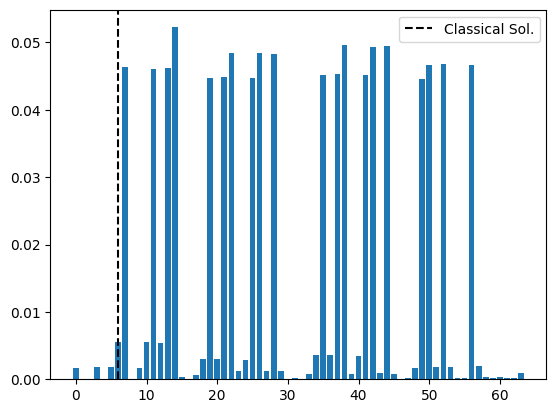

In [46]:
view_results(res, ansatz)

## With constraint

Suppose we have a budget $B \in N$ we must spend, i.e.
$$\sum_i x_i = B$$

In [25]:
budget = 3

## Classical Solution

In [26]:
costs = []
budget_solutions = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    if bin_i.count('1') == budget:
        costs.append(bin_string_to_cost(bin_i))
        budget_solutions.append(bin_i)
        print(f"Assets: {bin_i} Cost: {costs[-1]}")

classical_sol = np.argmin(costs)
print(f"\nBest solution: {budget_solutions[classical_sol]} Cost: {costs[classical_sol]}")

Assets: 000111 Cost: 0.062491505009910374
Assets: 001011 Cost: 0.06445454436685702
Assets: 001101 Cost: 0.06433888579234026
Assets: 001110 Cost: 0.0007219937773501293
Assets: 010011 Cost: 0.0966834453397951
Assets: 010101 Cost: 0.09663944437484785
Assets: 010110 Cost: 0.03383668054604615
Assets: 011001 Cost: 0.09817932427968239
Assets: 011010 Cost: 0.03495192501941437
Assets: 011100 Cost: 0.03588086398800387
Assets: 100011 Cost: 0.08659764255572124
Assets: 100101 Cost: 0.08578493192981158
Assets: 100110 Cost: 0.023213132979979095
Assets: 101001 Cost: 0.08818081819485202
Assets: 101010 Cost: 0.0251843838135532
Assets: 101100 Cost: 0.025344613121180314
Assets: 110001 Cost: 0.11980953331311298
Assets: 110010 Cost: 0.0576272271180026
Assets: 110100 Cost: 0.05785911403519921
Assets: 111000 Cost: 0.05940720541666122

Best solution: 001110 Cost: 0.0007219937773501293


## Quantum Solution
We can force our quantum algorithm to find such solution by introducing a penalty term in the cost function
$$
\begin{split}
C_{\text{penalty}} &= \lambda \left(\sum_i x_i - B\right)^2 = \lambda \left( \tilde n - \frac{1}{2}\sum_i z_i\right)^2 \\
&= \lambda \tilde n ^2 + \frac{\lambda}{4}\sum_{ij} z_iz_j - \lambda \tilde n \sum_i z_i  \\
\end{split}
$$
where $\tilde n = \frac{n - 2B}{2}.$

Thus our Hamiltonian is now

$$H = \sum_i  \left(c_i - \lambda \tilde n \right) Z_i + \sum_{i \ne j} \left(q\sigma_{ij}  + \frac{\lambda}{4} \right) Z_i Z_j  $$


In [27]:
n_tidle = (num_assets - 2*budget) / 2.

lambda_param = 1.0

hamiltonian = construct_hamiltonian(c - lambda_param*n_tidle, q * sigma + lambda_param / 4.)
hamiltonian

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'ZIZIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZZIII', 'IZIZII', 'IZIIZI', 'IZIIIZ', 'IIZZII', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[-0.04657675+0.j, -0.0671988 +0.j, -0.0024554 +0.j,  0.00105573+0.j,
  0.00117196+0.j, -0.12462724+0.j,  0.4990833 +0.j,  0.49969531+0.j,
  0.49922806+0.j,  0.4998851 +0.j,  0.49891228+0.j,  0.49970184+0.j,
  0.50009059+0.j,  0.49997892+0.j,  0.49923706+0.j,  0.50003076+0.j,
  0.49999075+0.j,  0.50006302+0.j,  0.49995634+0.j,  0.49960398+0.j,
  0.50053691+0.j])

In [28]:
res_qaoa = run_optimization(ansatz_qaoa, 2 * np.pi * np.random.rand(2*reps))

Current cost: 0.4744141086217208
Current cost: 0.03166121644467533
Current cost: 0.08527976378020613
Current cost: -0.016053980396875087
Current cost: 0.01916348753510013
Current cost: -0.007556346559538105
Current cost: 0.042487084492034755
Current cost: 0.02268740761579409
Current cost: -0.03263459220380328
Current cost: -0.03226179123645787
Current cost: -0.02599781953326047
Current cost: -0.02377969214942139
Current cost: -0.02515316745273506
Current cost: -0.018078084270697924
Current cost: -0.03246954318335583
Current cost: -0.03348706181126363
Current cost: -0.03482057974914241
Current cost: -0.03249326471667814
Current cost: -0.03499912513820488
Current cost: -0.03444587387078024
Current cost: -0.03458302743634109
Current cost: -0.03502933701692648
Current cost: -0.035086884156393446
Current cost: -0.03519897955805787
Current cost: -0.03508040716851439
Current cost: -0.034980691821010206
Current cost: -0.035381303191924146
Current cost: -0.03534154272256864
Current cost: -0.035

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.04922853919330192
       x: [ 1.547e+00  4.082e-01  4.947e+00  3.928e+00]
    nfev: 1000
   maxcv: 0.0


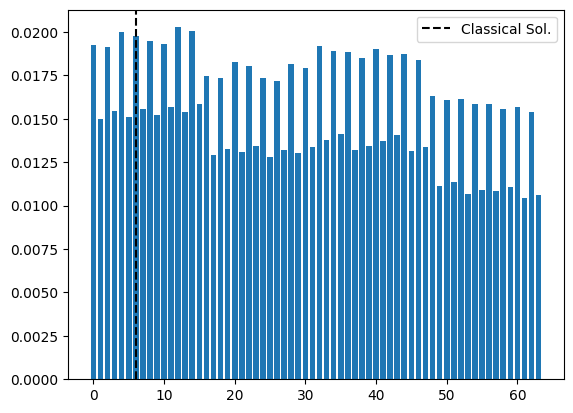

In [29]:
view_results(res_qaoa, ansatz_qaoa)